In [1]:
import types
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sb
import lime
import lime.lime_tabular
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold

Importation des librairies

Importation des données et fusion des DataFrame pour inclure une colonne classe. Les classes proviennent de la labelisation à la main.

Suppression des variables non pertinentes

Codage de la variable 'total_energy_consumption' en variable catégorielle. Catégorie 1 = consommation très faible, Catégorie 10 = consommation très élevée

On transforme certaines variables en catégories, afin d'éviter que le modèle introduise des notions d'ordre n'ayant pas lieu d'être. L'Id de job "3858710" n'est pas plus 'petit' que l'Id "3870799"

On sépare en Train/Test à hauteur de 70%, 30%

On génère un codage pour les variables catégorielles afin que le random forest puisse tourner

Création d'un modèle randomForest avec des paramètres par défaut. 100 arbres sont générés

Création du modèle lime permettant d'expliquer la prédiction du randomforest

Visualisation de l'explication de Lime 

In [2]:
data_7 = pd.read_csv(r'C:\\Users\\ibiza\\OneDrive\\Desktop\\Data\\1.csv')
classes = pd.read_csv(r'C:\\Users\\ibiza\\OneDrive\\Desktop\\Data\\Classeur1.csv')
data_7 = data_7.join(classes["classe"])
data_7.head(5)

,job_id,host_oar,cigri_oar,submission_time_oar,start_time_oar,stop_time_oar,processor,job_type_oar,job_user_oar,resource_ids_oar,...,max_amp_spec,dom_perdiod,dom_freq,energy_mean,energy_var,energy_coef_var,auto_correlation,significance_level,total_energy_consumption,classe
0,3858710,38,0,1561436840,1561436841,1561523248,1,PASSIVE,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",...,20.367383,36.0,-1,5.372342,0.397716,0.074030,0.512321,0.067266,4.561118e+11,12
1,3858710,38,0,1561436840,1561436841,1561523248,2,PASSIVE,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",...,6.942142,36.0,-1,5.941807,0.317332,0.053407,0.336247,0.067266,5.044594e+11,12
2,3858710,44,0,1561436840,1561436841,1561523248,1,PASSIVE,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",...,2.132627,36.0,-1,5.660922,0.252701,0.044640,0.092261,0.067266,4.806123e+11,12
3,3858710,44,0,1561436840,1561436841,1561523248,2,PASSIVE,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",...,2.054555,36.0,-1,5.886325,0.271917,0.046195,0.152256,0.067266,4.997490e+11,8
4,3858710,46,0,1561436840,1561436841,1561523248,1,PASSIVE,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",...,2.570486,36.0,-1,5.917699,0.257829,0.043569,0.098378,0.067266,5.024126e+11,12


In [3]:
data_7 = data_7.drop(columns=['job_id','cigri_oar','psetmin','psetmax','number_of_RAPL_observation', 'max_amp_spec',
       'dom_perdiod', 'dom_freq', 'energy_mean', 'energy_var',
       'energy_coef_var', 'auto_correlation', 'significance_level','start_time_oar','stop_time_oar','job_type_oar','nb_resources'])

In [4]:
data_7[["host_oar","processor","job_user_oar",
       "resource_ids_oar"]] = data_7[["host_oar","processor","job_user_oar",
       "resource_ids_oar"]].astype('category')

In [8]:
train_7,test_7=train_test_split(data_7,test_size=0.3,stratify=data_7['classe'],random_state=1)
train_7

,host_oar,submission_time_oar,processor,job_user_oar,resource_ids_oar,runtime_oar,total_energy_consumption,classe
224,67,1561667345,2,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",43211,4.239567e+11,12
323,35,1561766589,1,liyub,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",1809,1.711869e+10,5
35,68,1561465732,2,gorbunova,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",86409,8.571893e+11,10
366,47,1561891479,2,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",77479,7.567075e+11,12
657,37,1562326371,1,hansmsc90,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",6523,6.777003e+10,6
...,...,...,...,...,...,...,...,...
352,57,1561891184,2,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",86416,8.123860e+11,18
143,50,1561607333,2,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",2523,2.605094e+10,5
189,40,1561630318,1,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",21608,2.164687e+11,12
796,61,1562691227,2,hansmsc90,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",5695,5.910779e+10,6


In [9]:
train_7_processed = pd.get_dummies(train_7)
test_7_processed = pd.get_dummies(test_7)


In [10]:
X_train_7 = train_7_processed.drop(['classe'], axis=1)
Y_train_7 = train_7_processed['classe']

X_test_7  = test_7_processed.drop(['classe'], axis=1)
Y_test_7  = test_7_processed['classe']

In [11]:
X_train_7

,submission_time_oar,runtime_oar,total_energy_consumption,host_oar_33,host_oar_34,host_oar_35,host_oar_36,host_oar_37,host_oar_38,host_oar_40,...,job_user_oar_mariondonat,job_user_oar_mayagueguen,job_user_oar_monsimau,job_user_oar_ssimoussi,job_user_oar_thurinj,job_user_oar_veyralou2,job_user_oar_zhuh,"resource_ids_oar_1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16","resource_ids_oar_17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32","resource_ids_oar_18,18,19,19,20,20,21,21,22,22,23,23,24,24,25,25"
224,1561667345,43211,4.239567e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
323,1561766589,1809,1.711869e+10,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35,1561465732,86409,8.571893e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
366,1561891479,77479,7.567075e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
657,1562326371,6523,6.777003e+10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,1561891184,86416,8.123860e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
143,1561607333,2523,2.605094e+10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
189,1561630318,21608,2.164687e+11,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
796,1562691227,5695,5.910779e+10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_train_7, Y_train_7)
random_forest_preds_7 = random_forest.predict(X_test_7)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(random_forest_preds_7,Y_test_7))

The accuracy of the Random Forests model is :	 0.7208333333333333


In [13]:
parameter_grid = {'n_estimators': [100, 200,300,400,500],
                  'criterion': ['gini', 'entropy'],
                  'min_samples_split': [2,5,10,8],
                  'max_features': [1, 2, 3, 4,5]}

cross_validation = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(random_forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train_7,Y_train_7)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best = grid_search.best_estimator_

C:\Users\ibiza\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ibiza\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.6642728904847397
Best parameters: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 200}


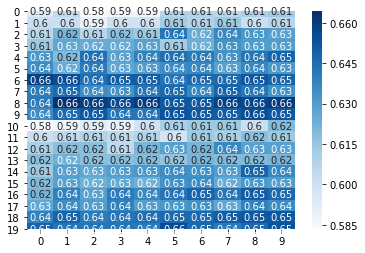

In [14]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (20,10)
sn.heatmap(grid_visualization, cmap='Blues', annot=True) 

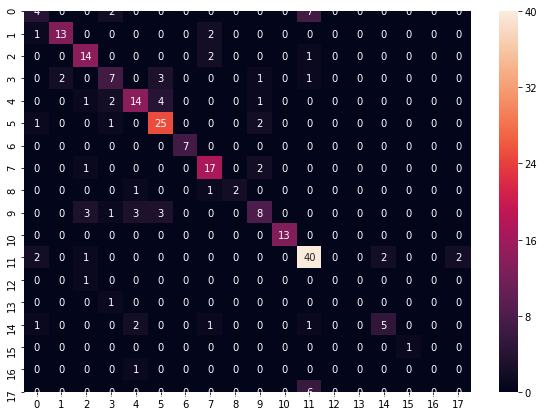

In [15]:
mt = confusion_matrix(Y_test_7, best.predict(X_test_7))
plt.figure(figsize = (10,7))
sn.heatmap(mt, annot=True)
plt.show()

In [16]:
print(metrics.classification_report(Y_test_7 , best.predict(X_test_7), labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]))

              precision    recall  f1-score   support

           1       0.44      0.31      0.36        13
           2       0.87      0.81      0.84        16
           3       0.67      0.82      0.74        17
           4       0.50      0.50      0.50        14
           5       0.67      0.64      0.65        22
           6       0.71      0.86      0.78        29
           7       1.00      1.00      1.00         7
           8       0.74      0.85      0.79        20
           9       1.00      0.50      0.67         4
          10       0.57      0.44      0.50        18
          11       1.00      1.00      1.00        13
          12       0.71      0.85      0.78        47
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.71      0.50      0.59        10
          16       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         1
          18       0.00    

C:\Users\ibiza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ibiza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [17]:
random_forest_tuned = RandomForestClassifier(n_estimators=400,criterion= 'gini',
                                             max_features= 5, min_samples_split =2)
random_forest_tuned.fit(X_train_7, Y_train_7)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
predict_fn_rf = lambda x: random_forest_tuned.predict_proba(x).astype(float)
X = X_train_7.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train_7.columns,class_names=['Classe 1','Classe 2','Classe 3','Classe 4',
                                                                                                 'Classe 5','Classe 6','Classe 7','Classe 8',
                                                                                                 'Classe 9','Classe 10','Classe 11','Classe 12',
                                                                                                 'Classe 13','Classe 14','Classe 15','Classe 16',
                                                                                                 'Classe 17','Classe 18','Classe 19'],kernel_width=5)

In [19]:
test_7.head()

,host_oar,submission_time_oar,processor,job_user_oar,resource_ids_oar,runtime_oar,total_energy_consumption,classe
666,70,1562336474,2,hansmsc90,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",24645,2.558931e+11,3
494,47,1562072639,2,glesur,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",5086,7.801648e+09,9
523,50,1562133572,1,hewg,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",57603,5.966260e+11,7
113,69,1561551500,2,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",43210,4.400571e+11,1
793,59,1562690863,1,hansmsc90,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",5656,5.857977e+10,4


In [25]:
choosen_instance = X_test_7.loc[[523]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10,top_labels=5)
exp.show_in_notebook(show_all=False)

In [18]:
data = pd.read_csv(r'C:\\Users\\ibiza\\OneDrive\\Desktop\\Data\\1.csv')
classes = pd.read_csv(r'C:\\Users\\ibiza\\OneDrive\\Desktop\\Data\\Classeur1.csv')
data = data.join(classes["classe"])
df =data[data["job_user_oar"]=="irnakat"]
df.head()

,job_id,host_oar,cigri_oar,submission_time_oar,start_time_oar,stop_time_oar,processor,job_type_oar,job_user_oar,resource_ids_oar,...,max_amp_spec,dom_perdiod,dom_freq,energy_mean,energy_var,energy_coef_var,auto_correlation,significance_level,total_energy_consumption,classe
0,3858710,38,0,1561436840,1561436841,1561523248,1,PASSIVE,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",...,20.367383,36.0,-1,5.372342,0.397716,0.074030,0.512321,0.067266,4.561118e+11,12
1,3858710,38,0,1561436840,1561436841,1561523248,2,PASSIVE,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",...,6.942142,36.0,-1,5.941807,0.317332,0.053407,0.336247,0.067266,5.044594e+11,12
2,3858710,44,0,1561436840,1561436841,1561523248,1,PASSIVE,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",...,2.132627,36.0,-1,5.660922,0.252701,0.044640,0.092261,0.067266,4.806123e+11,12
3,3858710,44,0,1561436840,1561436841,1561523248,2,PASSIVE,irnakat,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",...,2.054555,36.0,-1,5.886325,0.271917,0.046195,0.152256,0.067266,4.997490e+11,8
4,3858710,46,0,1561436840,1561436841,1561523248,1,PASSIVE,irnakat,"17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32",...,2.570486,36.0,-1,5.917699,0.257829,0.043569,0.098378,0.067266,5.024126e+11,12


In [20]:
guys = data["job_user_oar"].unique()
guys

array(['irnakat', 'cfalvo', 'glesur', 'gorbunova', 'amartinez', 'levan',
       'mariondonat', 'bonamy', 'liyub', 'arnaudpladys', 'veyralou2',
       'baladimf', 'thurinj', 'monsimau', 'hewg', 'mayagueguen',
       'bremond', 'liy', 'hansmsc90', 'leonard', 'lalandmi', 'brossier',
       'zhuh', 'ssimoussi'], dtype=object)

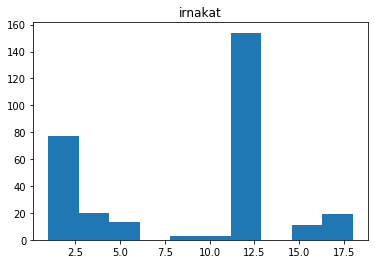

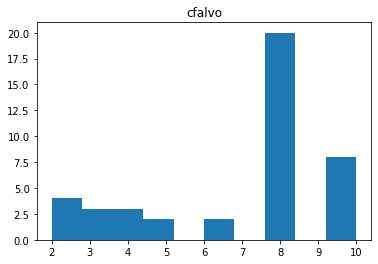

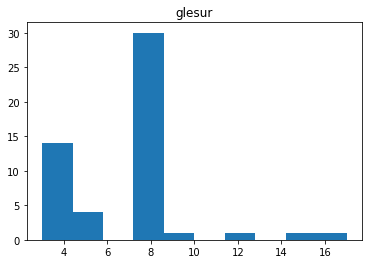

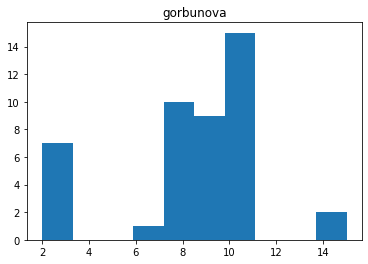

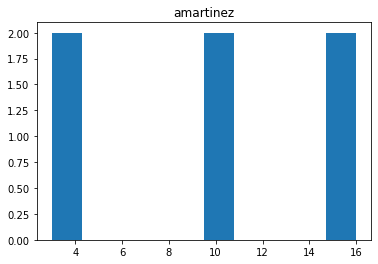

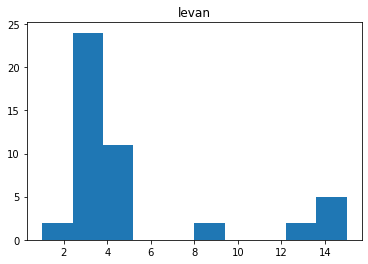

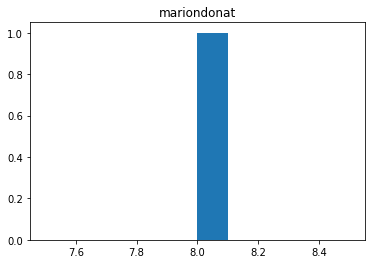

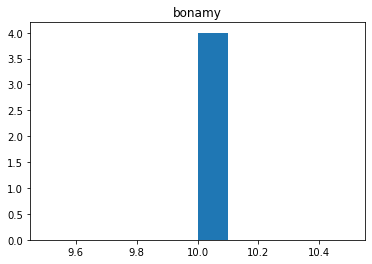

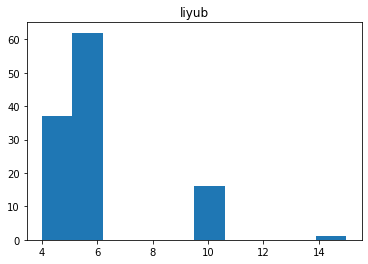

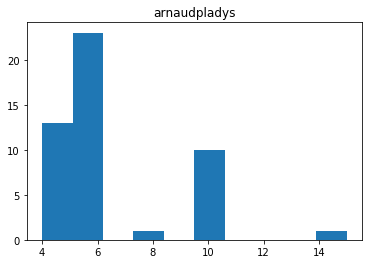

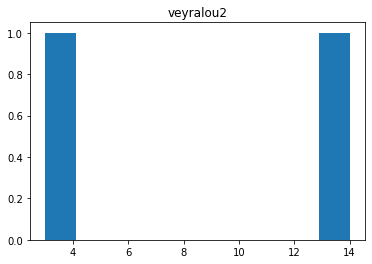

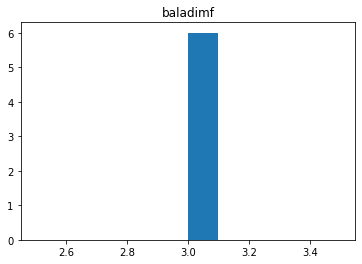

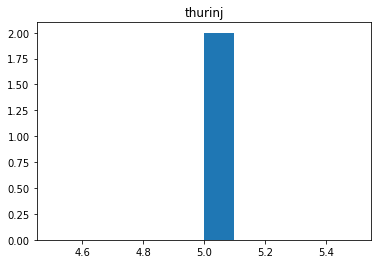

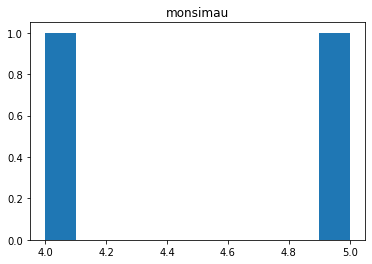

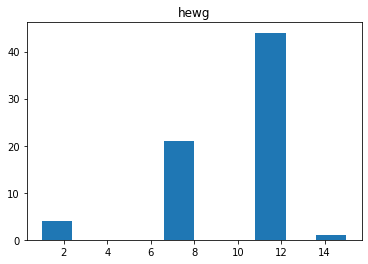

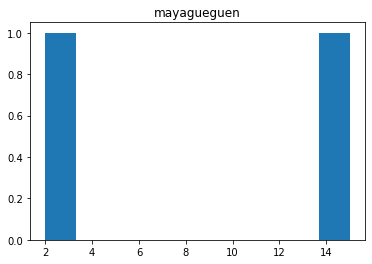

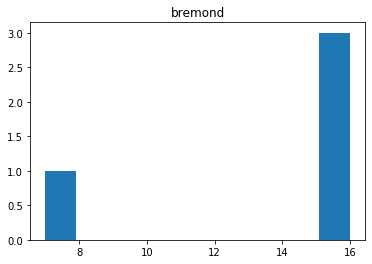

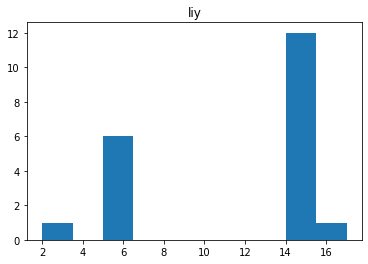

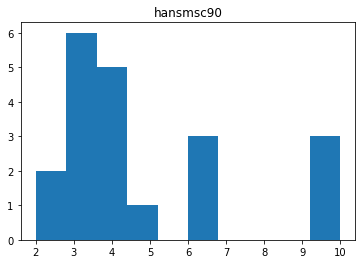

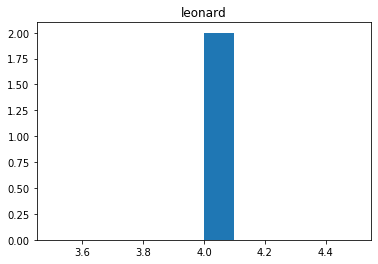

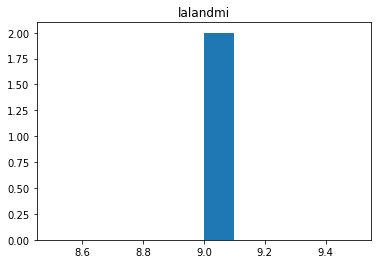

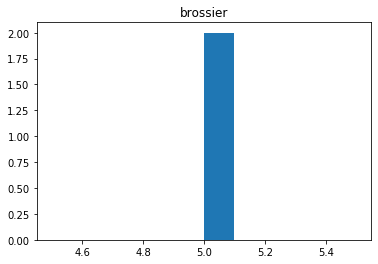

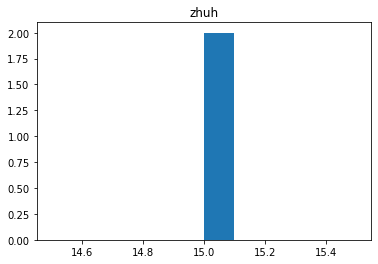

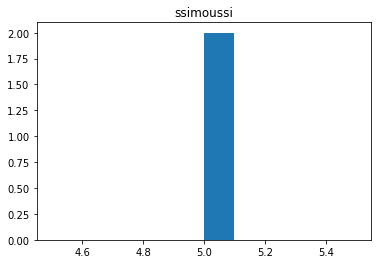

In [21]:
for guy in guys :
    plt.hist(data[data["job_user_oar"]==guy]["classe"])
    plt.title(guy)
    plt.show()


In [22]:
machines = data["host_oar"].unique()
machines

array([38, 44, 46, 40, 42, 43, 47, 50, 51, 52, 53, 57, 71, 58, 62, 63, 66,
       68, 55, 37, 59, 60, 70, 67, 54, 65, 69, 34, 35, 72, 61, 56, 64, 49,
       33, 41, 36], dtype=int64)

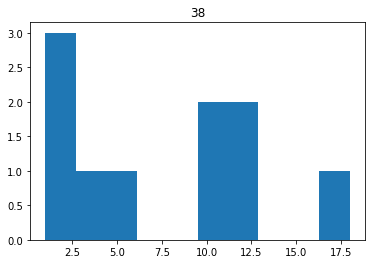

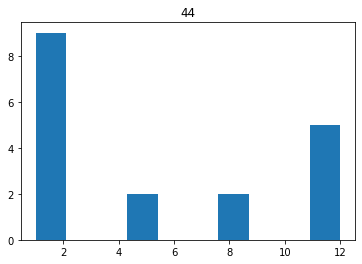

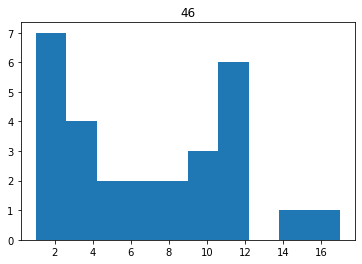

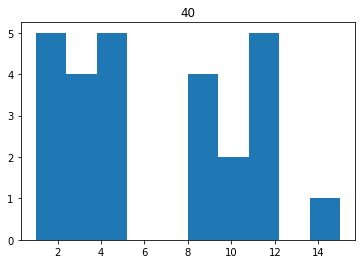

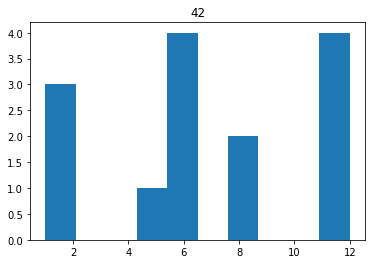

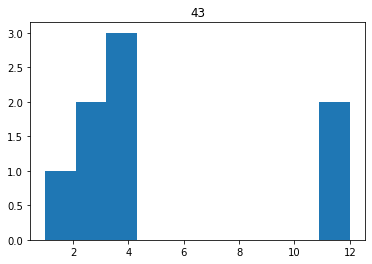

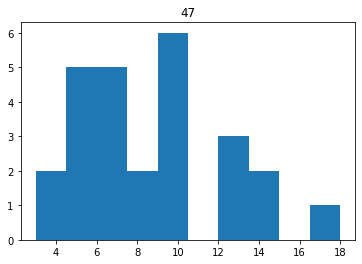

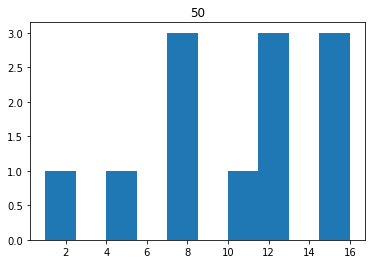

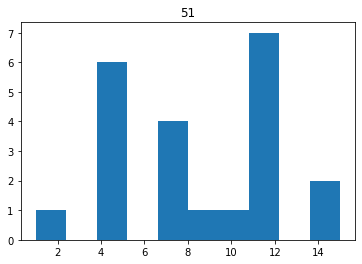

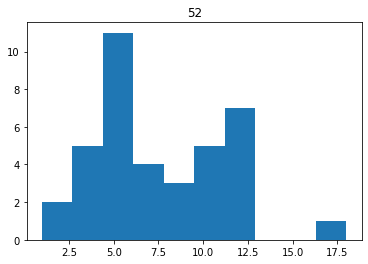

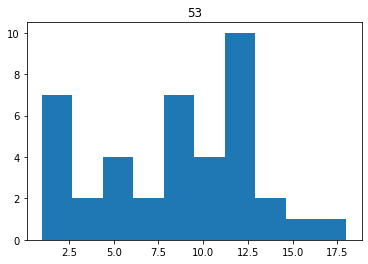

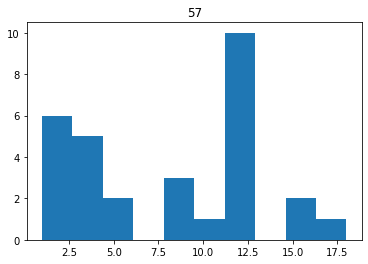

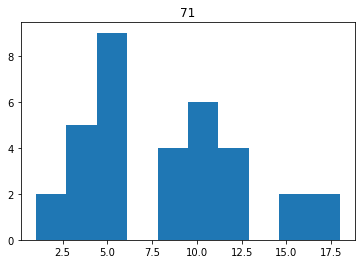

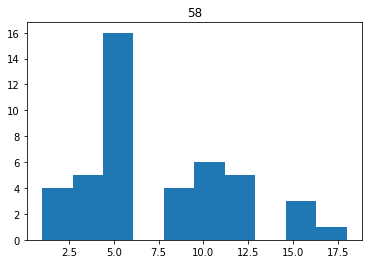

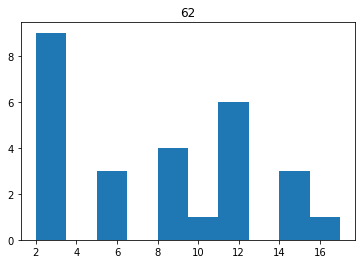

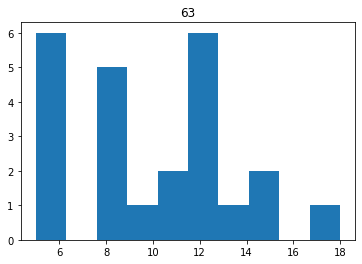

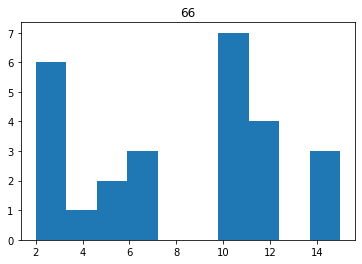

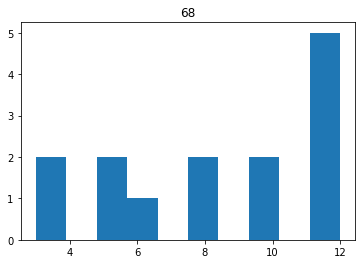

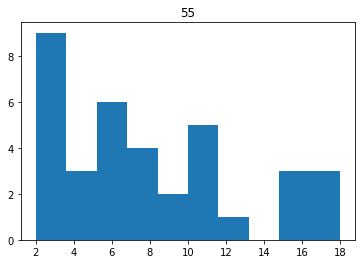

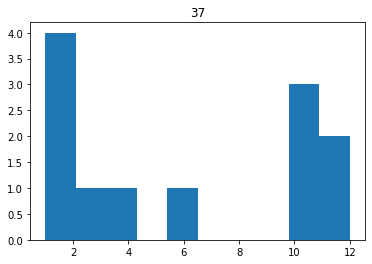

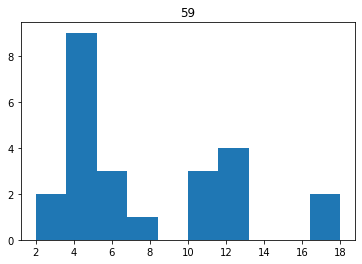

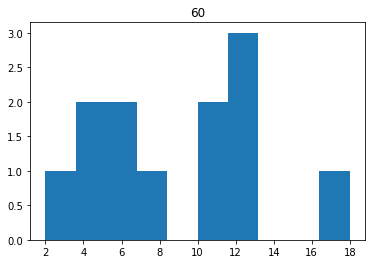

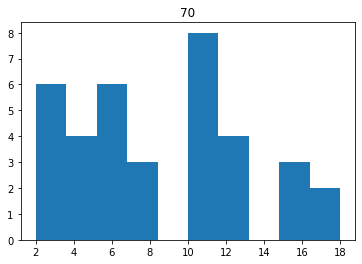

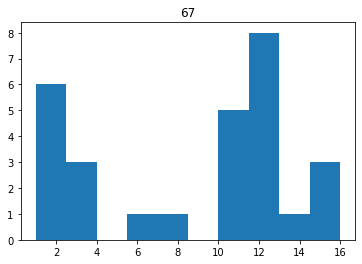

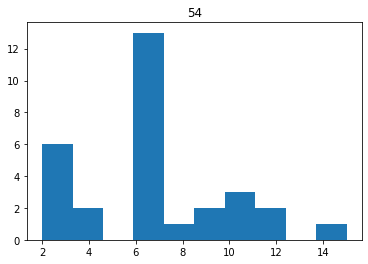

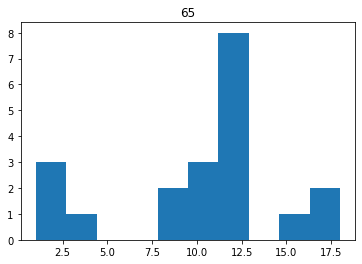

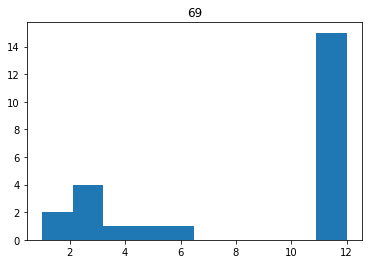

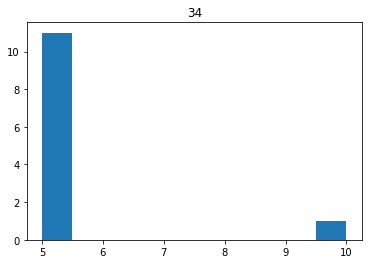

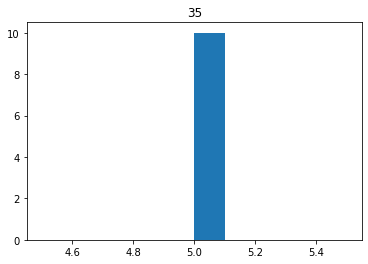

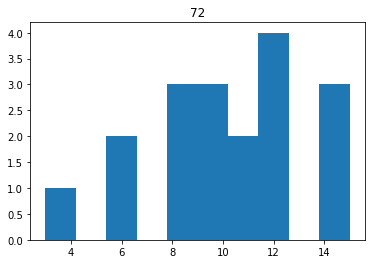

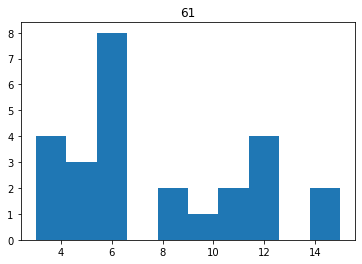

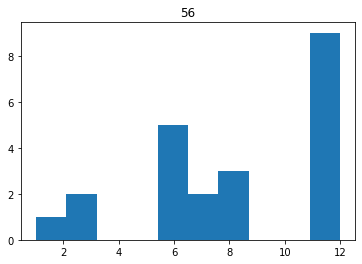

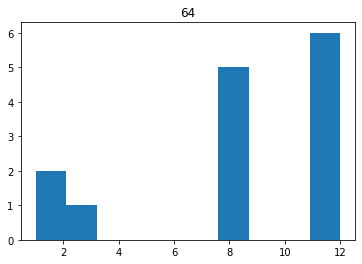

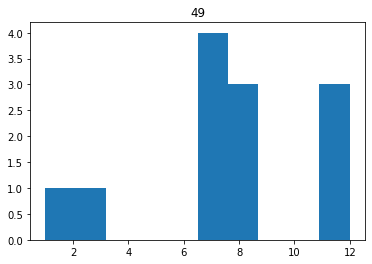

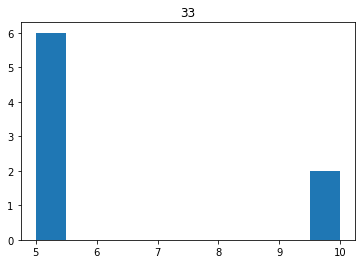

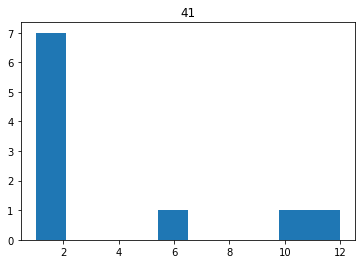

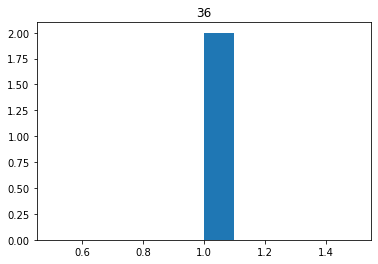

In [23]:
for machine in machines :
    plt.hist(data[data["host_oar"]==machine]["classe"])
    plt.title(machine)
    plt.show()